# ECG-Pytorch-Quantization Compression

@create 2021-09-13
@author 孙寒石
@env Pytorch 1.9.0 Python 3.7

## Import Packages

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Prepare Dataset

In [2]:
import os
import scipy.io as scio
from sklearn.model_selection import train_test_split

base_path = './'
dataset_path =  './Dataset' # Training data

classes = ['NSR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW','PVC', 'Bigeminy', 'Trigeminy', 
           'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR']
ClassesNum = len(classes)

X = list()
y = list()

for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
        data_train = scio.loadmat(os.path.join(root, name))# 取出字典里的value
        
        # arr -> list
        data_arr = data_train.get('val')
        data_list = data_arr.tolist()
        
        X.append(data_list[0]) # [[……]] -> [ ]
        y.append(int(os.path.basename(root)[0:2]) - 1)  # name -> num
        
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
        
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma
    
X=np.array(X)
y=np.array(y)
X = standardization(X)
X = X.reshape((1000,1,3600))
y = y.reshape((1000))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("shape of X_train : ", np.shape(X_train[0]))
print("shape of y_train : ", np.shape(y_train))
print("shape of X_test : ", np.shape(X_test))
print("shape of y_test : ", np.shape(y_test))

X_train :  800
X_test  :  200
shape of X_train :  (1, 3600)
shape of y_train :  (800,)
shape of X_test :  (200, 1, 3600)
shape of y_test :  (200,)


In [3]:
batch_size = 16
class MyDataset(Dataset):
    def __init__(self):
        self.len = X_train.shape[0] # 取第0元素：长度
        self.x_train = torch.from_numpy(X_train).float()
        self.y_train = torch.from_numpy(y_train).long()
    def __getitem__(self, index):
        return self.x_train[index], self.y_train[index] # 返回对应样本即可
    def __len__(self):
        return self.len
    
class TestDataset(Dataset):
    def __init__(self):
        self.len = X_test.shape[0] # 取第0元素：长度
        self.x_test = torch.from_numpy(X_test).float()
        self.y_test = torch.from_numpy(y_test).long()
    def __getitem__(self, index):
        return self.x_test[index], self.y_test[index] # 返回对应样本即可
    def __len__(self):
        return self.len    
        
train_dataset = MyDataset()
test_dataset = TestDataset()
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)
test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)

## Design Model

In [4]:
in_channels_ = 1
num_segments_in_record = 100
segment_len = 3600   # 3600 采样
num_classes = 17

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class arrhythmia_classifier(nn.Module):
    def __init__(self, in_channels=in_channels_):
        super(arrhythmia_classifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1,8,16,stride=2,padding=7),
            nn.ReLU(),
            #nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=8,stride=4),
   
            nn.Conv1d(8,12,12,padding=5,stride=2),
            nn.ReLU(),
            #nn.BatchNorm1d(16),
            nn.MaxPool1d(4,stride=2),
            
            nn.Conv1d(12,32,9,stride=1,padding=4),
            nn.ReLU(),
            nn.MaxPool1d(5,stride=2),
            
            nn.Conv1d(32,64,7,stride=1,padding=3),
            nn.ReLU(),
            nn.MaxPool1d(4,stride=2),
            
            nn.Conv1d(64,64,5,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            
            nn.Conv1d(64,64,3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            
            nn.Conv1d(64,72,3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            Flatten(),
            nn.Linear(in_features=216, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=.1),
            nn.Linear(in_features=64, out_features=17),
        )

    def forward(self, x, ex_features=None):
        return self.cnn(x)


def calc_next_len_conv1d(current_len=112500, kernel_size=16, stride=8, padding=0, dilation=1):
    return int(np.floor((current_len + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1))
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = arrhythmia_classifier().to("cpu")
#from torchsummary import summary
#summary(model, input_size=(1, 3600))

In [5]:
print(model)

arrhythmia_classifier(
  (cnn): Sequential(
    (0): Conv1d(1, 8, kernel_size=(16,), stride=(2,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=8, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(8, 12, kernel_size=(12,), stride=(2,), padding=(5,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(12, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (10): ReLU()
    (11): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (13): ReLU()
    (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (16): ReLU()
    (17): MaxPool1d(

## Construct Loss and Optimizer

In [6]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay = 0.0, amsgrad = False)

## Train

In [7]:
correct_list = []
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()
        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 10 == 9:
            print('[%d, %5d] loss: %.8f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            running_loss = 0.0


def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    correct_list.append(100 * correct / total)
    print('Accuracy on test set: %.8f %%' % (100 * correct / total))
    
    
for epoch in range(300):
    train(epoch)
    test()

/home/preminstrel/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,    10] loss: 0.09426802
[1,    20] loss: 0.09386128
[1,    30] loss: 0.09279943
[1,    40] loss: 0.08770464
[1,    50] loss: 0.08124818
Accuracy on test set: 30.50000000 %
[2,    10] loss: 0.08046250
[2,    20] loss: 0.08163511
[2,    30] loss: 0.07431894
[2,    40] loss: 0.08281795
[2,    50] loss: 0.07965120
Accuracy on test set: 30.50000000 %
[3,    10] loss: 0.07688228
[3,    20] loss: 0.07808538
[3,    30] loss: 0.07993612
[3,    40] loss: 0.07621053
[3,    50] loss: 0.08163842
Accuracy on test set: 29.00000000 %
[4,    10] loss: 0.07688414
[4,    20] loss: 0.07532211
[4,    30] loss: 0.07997570
[4,    40] loss: 0.08155577
[4,    50] loss: 0.07594351
Accuracy on test set: 30.00000000 %
[5,    10] loss: 0.07788884
[5,    20] loss: 0.07967939
[5,    30] loss: 0.07608105
[5,    40] loss: 0.07674058
[5,    50] loss: 0.07419710
Accuracy on test set: 30.00000000 %
[6,    10] loss: 0.07759050
[6,    20] loss: 0.07313056
[6,    30] loss: 0.07268157
[6,    40] loss: 0.07277789
[6,    5

[47,    10] loss: 0.01057307
[47,    20] loss: 0.01385754
[47,    30] loss: 0.01358124
[47,    40] loss: 0.01310692
[47,    50] loss: 0.00804048
Accuracy on test set: 86.00000000 %
[48,    10] loss: 0.01017858
[48,    20] loss: 0.00855119
[48,    30] loss: 0.00684626
[48,    40] loss: 0.01017300
[48,    50] loss: 0.01095837
Accuracy on test set: 83.50000000 %
[49,    10] loss: 0.00953491
[49,    20] loss: 0.00939381
[49,    30] loss: 0.00936130
[49,    40] loss: 0.01107887
[49,    50] loss: 0.00894821
Accuracy on test set: 84.00000000 %
[50,    10] loss: 0.00916556
[50,    20] loss: 0.01146240
[50,    30] loss: 0.00891414
[50,    40] loss: 0.00767624
[50,    50] loss: 0.00762779
Accuracy on test set: 83.00000000 %
[51,    10] loss: 0.00817304
[51,    20] loss: 0.01078612
[51,    30] loss: 0.00932359
[51,    40] loss: 0.00988714
[51,    50] loss: 0.01081927
Accuracy on test set: 86.50000000 %
[52,    10] loss: 0.00761615
[52,    20] loss: 0.00879526
[52,    30] loss: 0.00641339
[52,    

[92,    30] loss: 0.00471302
[92,    40] loss: 0.00552584
[92,    50] loss: 0.00897640
Accuracy on test set: 87.00000000 %
[93,    10] loss: 0.00172204
[93,    20] loss: 0.00363208
[93,    30] loss: 0.00398778
[93,    40] loss: 0.00123630
[93,    50] loss: 0.00097425
Accuracy on test set: 89.50000000 %
[94,    10] loss: 0.00090513
[94,    20] loss: 0.00182234
[94,    30] loss: 0.00169386
[94,    40] loss: 0.00137080
[94,    50] loss: 0.00120380
Accuracy on test set: 89.00000000 %
[95,    10] loss: 0.00072963
[95,    20] loss: 0.00070200
[95,    30] loss: 0.00180124
[95,    40] loss: 0.00125771
[95,    50] loss: 0.00237777
Accuracy on test set: 89.50000000 %
[96,    10] loss: 0.00141206
[96,    20] loss: 0.00159740
[96,    30] loss: 0.00220480
[96,    40] loss: 0.00088627
[96,    50] loss: 0.00142172
Accuracy on test set: 89.00000000 %
[97,    10] loss: 0.00110195
[97,    20] loss: 0.00153787
[97,    30] loss: 0.00256756
[97,    40] loss: 0.00372413
[97,    50] loss: 0.00148476
Accuracy

[137,    10] loss: 0.00308348
[137,    20] loss: 0.00308871
[137,    30] loss: 0.00144661
[137,    40] loss: 0.00225675
[137,    50] loss: 0.00078989
Accuracy on test set: 89.50000000 %
[138,    10] loss: 0.00106190
[138,    20] loss: 0.00048627
[138,    30] loss: 0.00070523
[138,    40] loss: 0.00098954
[138,    50] loss: 0.00074972
Accuracy on test set: 88.00000000 %
[139,    10] loss: 0.00080390
[139,    20] loss: 0.00042920
[139,    30] loss: 0.00030245
[139,    40] loss: 0.00071686
[139,    50] loss: 0.00261484
Accuracy on test set: 89.50000000 %
[140,    10] loss: 0.00035137
[140,    20] loss: 0.00384650
[140,    30] loss: 0.00149422
[140,    40] loss: 0.00363850
[140,    50] loss: 0.00353356
Accuracy on test set: 84.00000000 %
[141,    10] loss: 0.00194562
[141,    20] loss: 0.00255536
[141,    30] loss: 0.00064343
[141,    40] loss: 0.00117397
[141,    50] loss: 0.00266182
Accuracy on test set: 88.50000000 %
[142,    10] loss: 0.00097062
[142,    20] loss: 0.00200365
[142,    3

[181,    30] loss: 0.00055149
[181,    40] loss: 0.00051911
[181,    50] loss: 0.00078928
Accuracy on test set: 90.00000000 %
[182,    10] loss: 0.00026642
[182,    20] loss: 0.00022699
[182,    30] loss: 0.00014350
[182,    40] loss: 0.00035782
[182,    50] loss: 0.00018499
Accuracy on test set: 91.00000000 %
[183,    10] loss: 0.00068517
[183,    20] loss: 0.00013527
[183,    30] loss: 0.00009776
[183,    40] loss: 0.00052572
[183,    50] loss: 0.00020710
Accuracy on test set: 90.00000000 %
[184,    10] loss: 0.00026128
[184,    20] loss: 0.00009644
[184,    30] loss: 0.00022652
[184,    40] loss: 0.00019885
[184,    50] loss: 0.00025624
Accuracy on test set: 91.50000000 %
[185,    10] loss: 0.00012454
[185,    20] loss: 0.00010144
[185,    30] loss: 0.00019559
[185,    40] loss: 0.00008542
[185,    50] loss: 0.00005732
Accuracy on test set: 91.00000000 %
[186,    10] loss: 0.00004882
[186,    20] loss: 0.00006423
[186,    30] loss: 0.00009488
[186,    40] loss: 0.00006490
[186,    5

[225,    40] loss: 0.00010355
[225,    50] loss: 0.00007917
Accuracy on test set: 89.50000000 %
[226,    10] loss: 0.00020201
[226,    20] loss: 0.00009657
[226,    30] loss: 0.00005346
[226,    40] loss: 0.00008584
[226,    50] loss: 0.00002363
Accuracy on test set: 88.50000000 %
[227,    10] loss: 0.00004484
[227,    20] loss: 0.00007557
[227,    30] loss: 0.00002880
[227,    40] loss: 0.00005667
[227,    50] loss: 0.00005910
Accuracy on test set: 90.50000000 %
[228,    10] loss: 0.00034835
[228,    20] loss: 0.00036530
[228,    30] loss: 0.00068952
[228,    40] loss: 0.00279892
[228,    50] loss: 0.00431714
Accuracy on test set: 88.50000000 %
[229,    10] loss: 0.00067012
[229,    20] loss: 0.00396663
[229,    30] loss: 0.00086245
[229,    40] loss: 0.00114177
[229,    50] loss: 0.00085440
Accuracy on test set: 89.50000000 %
[230,    10] loss: 0.00049195
[230,    20] loss: 0.00055765
[230,    30] loss: 0.00137147
[230,    40] loss: 0.00217987
[230,    50] loss: 0.00029198
Accuracy o

Accuracy on test set: 92.00000000 %
[270,    10] loss: 0.00006559
[270,    20] loss: 0.00010882
[270,    30] loss: 0.00003546
[270,    40] loss: 0.00002810
[270,    50] loss: 0.00003855
Accuracy on test set: 92.50000000 %
[271,    10] loss: 0.00007260
[271,    20] loss: 0.00003534
[271,    30] loss: 0.00001143
[271,    40] loss: 0.00001461
[271,    50] loss: 0.00000713
Accuracy on test set: 92.00000000 %
[272,    10] loss: 0.00001115
[272,    20] loss: 0.00006285
[272,    30] loss: 0.00000594
[272,    40] loss: 0.00000915
[272,    50] loss: 0.00001105
Accuracy on test set: 91.00000000 %
[273,    10] loss: 0.00018187
[273,    20] loss: 0.00007288
[273,    30] loss: 0.00000566
[273,    40] loss: 0.00001811
[273,    50] loss: 0.00002177
Accuracy on test set: 90.50000000 %
[274,    10] loss: 0.00002938
[274,    20] loss: 0.00001475
[274,    30] loss: 0.00008039
[274,    40] loss: 0.00005050
[274,    50] loss: 0.00002197
Accuracy on test set: 90.50000000 %
[275,    10] loss: 0.00004637
[275

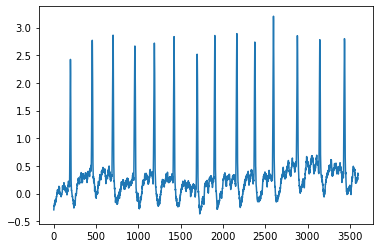

In [8]:
t=np.arange(3600)
p = X_train[1,:,:].reshape((3600))
plt.plot(t,p)

In [9]:
correct = 0
total = 0
with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            print(predicted)
            print(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
print('Accuracy on test set: %d %%' % (100 * correct / total))

tensor([ 3,  0,  6,  6,  0, 14,  6,  0,  0,  0,  0,  4,  0,  1,  6,  0])
tensor([ 3,  0,  6,  6,  0, 14,  6,  0,  0,  0,  1,  1,  0,  1,  6,  0])
tensor([ 6, 16,  3,  0,  0,  6, 13,  0,  2, 16,  0,  6,  0,  3,  3,  0])
tensor([ 6, 16,  3,  0,  0,  6, 13,  0,  4, 16,  0,  6,  0,  3,  3,  0])
tensor([14,  0,  3,  0,  0, 14,  3,  3, 13,  6, 15,  3, 13,  1, 14,  0])
tensor([14,  0,  3,  0,  0, 14,  3,  3, 13,  6, 15,  3, 13,  1, 14,  0])
tensor([ 5,  6,  8,  3,  5,  3,  0,  7,  6,  0,  3,  0,  6,  6, 13,  0])
tensor([ 5,  6,  8,  8,  5,  3,  1,  7,  6,  0,  3,  0,  6,  6, 13,  0])
tensor([13,  6, 14,  0,  3, 13,  0,  3,  6,  6,  0,  3,  5,  1,  3, 14])
tensor([13,  6, 14,  0,  3, 13,  0,  3,  6,  6,  0,  3,  5,  0,  3, 14])
tensor([ 7,  1,  6, 13,  6,  0, 13, 16, 13,  0,  9, 13,  3,  2, 13,  3])
tensor([ 6,  1,  6, 13,  6,  0,  3, 16, 13,  0,  9, 13,  3,  2, 13,  3])
tensor([ 0,  0, 13,  6, 13,  3,  2, 13, 13,  0,  7,  8,  0,  3,  0,  7])
tensor([ 0,  0, 13,  6, 13,  3,  2, 13, 13,  0,  6,

Text(0, 0.5, 'Accuracy(%)')

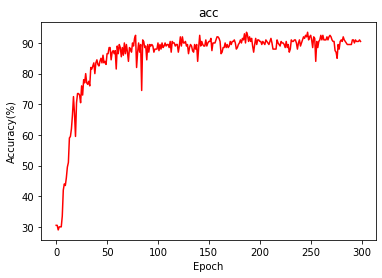

In [13]:
plt.rcParams['axes.grid'] = False
plt.plot(correct_list,'r')
plt.title('acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')

In [41]:
import itertools
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:
def confusion_matrix(preds, labels, conf_matrix):
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix
conf_matrix = torch.zeros(17, 17)

In [43]:
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        out = model(images)
        prediction = torch.max(out, 1)[1]
        conf_matrix = confusion_matrix(prediction, labels=labels, conf_matrix=conf_matrix)

Normalized confusion matrix
[[0.96666667 0.03333333 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.125      0.875      0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.8        0.         0.2        0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.96774194 0.         0.
  0.         0.         0.03225806 0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.       

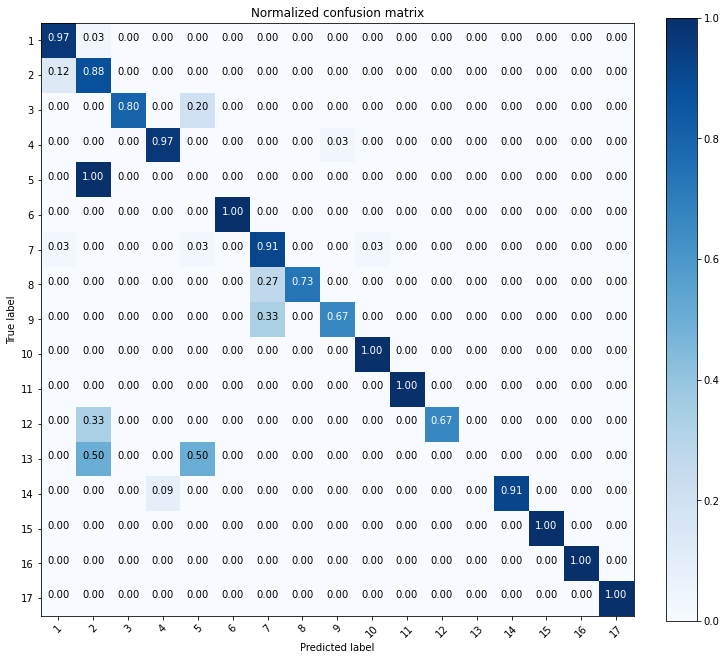

In [44]:
attack_types=['1', '2', '3', '4', '5','6','7','8','9','10','11','12','13','14','15','16','17']
plt.figure(figsize=(10,10))
plot_confusion_matrix(conf_matrix.numpy(), classes=attack_types, normalize=True, title='Normalized confusion matrix')

## Quantization

In [51]:
qconfig = torch.quantization.get_default_qconfig('qnnpack')
torch.backends.quantized.engine = 'qnnpack'